In [29]:
from __future__ import print_function, division
from builtins import range

In [30]:
import warnings
warnings.filterwarnings('ignore')

In [31]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Embedding
from keras.layers import Conv1D, LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.models import Model
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score

In [32]:
import keras.backend as K

In [33]:
# Download the word vectors:
# http://nlp.stanford.edu/data/glove.6B.zip

In [34]:
MAX_SEQUENCE_LENGTH = 200
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 100

In [35]:
# load in pre-tained word vectors
print("Loading word vectors...")
word2vec = {}
with open(os.path.join('data/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [36]:
# prepare the text smaples and their labels
print('Loading in data...')

attack_data = pd.read_csv('data/attackset.csv')
attack_data = attack_data.sample(frac=1).reset_index(drop=True)
sentences = attack_data['Web Description'].fillna('DUMMY_VALUE').values
possible_labels = ['Bruteforce', 'DoS', 'insider', 'phishing', 'ransomware', 'Trojan', 'Web']
targets = attack_data[possible_labels].values

Loading in data...


In [37]:
# convert the sentences into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [38]:
print('max sequence length: ', max(len(s) for s in sentences))
print('min sequence length: ', min(len(s) for s in sentences))
s = sorted(len(s) for s in sequences)
print('median sequence length: ', s[len(s) // 2])
print('max word index: ', max(max(seq) for seq in sequences if len(seq) > 0))

max sequence length:  3297
min sequence length:  32
median sequence length:  106
max word index:  4169


In [39]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 4169 unique tokens.


In [40]:
# pad sequence so that we get N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor: ', data.shape)

Shape of data tensor:  (785, 200)


In [41]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) +1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all zeros
            embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [42]:
from sklearn.model_selection import train_test_split    
from sklearn.preprocessing import MinMaxScaler

In [43]:
X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=VALIDATION_SPLIT, random_state=101)

In [44]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False
)

In [45]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, SpatialDropout1D
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [46]:
print('Building model...')
import time
start_time = time.time()
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = LSTM(15, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
# x = Bidirectional(LSTM(15, return_sequences=True))(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)
print("--- %s seconds ---" % (time.time() - start_time))

Building model...
--- 0.1459348201751709 seconds ---


In [47]:
import time
start_time = time.time()
model = Model(input_, output)
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(lr=0.01),
    metrics=['accuracy']
)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.006541013717651367 seconds ---


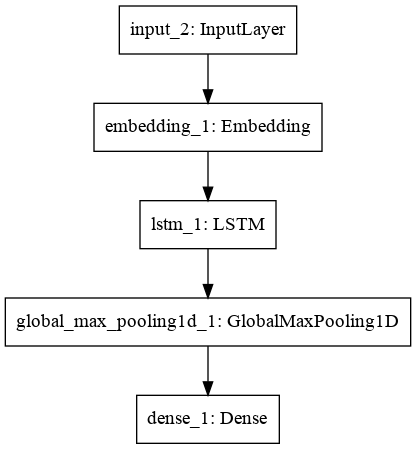

In [48]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot_rnn.png')

In [49]:
print('Training model...')
import time
start_time = time.time()
r = model.fit(
    X_train,y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test)
)
print("--- %s seconds ---" % (time.time() - start_time))

Training model...
Epoch 1/100
5/5 [==============================] - 5s 467ms/step - loss: 0.6462 - accuracy: 0.1099 - val_loss: 0.4856 - val_accuracy: 0.2611
Epoch 2/100
5/5 [==============================] - 2s 444ms/step - loss: 0.4663 - accuracy: 0.2625 - val_loss: 0.4056 - val_accuracy: 0.2611
Epoch 3/100
5/5 [==============================] - 3s 559ms/step - loss: 0.3943 - accuracy: 0.2501 - val_loss: 0.3500 - val_accuracy: 0.2675
Epoch 4/100
5/5 [==============================] - 3s 737ms/step - loss: 0.3457 - accuracy: 0.4257 - val_loss: 0.3142 - val_accuracy: 0.7389
Epoch 5/100
5/5 [==============================] - 4s 842ms/step - loss: 0.3110 - accuracy: 0.7030 - val_loss: 0.2913 - val_accuracy: 0.6879
Epoch 6/100
5/5 [==============================] - 2s 441ms/step - loss: 0.2876 - accuracy: 0.6859 - val_loss: 0.2754 - val_accuracy: 0.6879
Epoch 7/100
5/5 [==============================] - 3s 606ms/step - loss: 0.2797 - accuracy: 0.6565 - val_loss: 0.2659 - val_accuracy: 0.

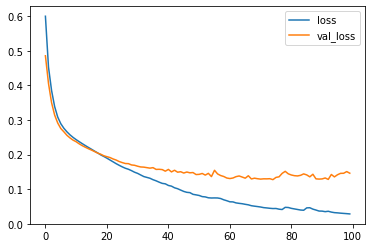

In [50]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

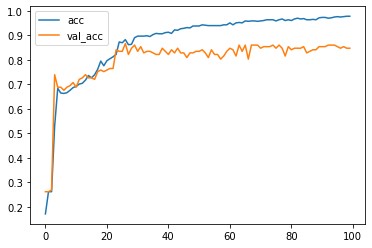

In [51]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [52]:
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

0.9664023197632124


In [53]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer

In [54]:
import time
start_time = time.time()
probability = model.predict(X_test)
print("--- %s seconds ---" % (time.time() - start_time))

--- 1.5018839836120605 seconds ---


In [55]:
thresh = 0.5
predictions = np.array([[1 if i > thresh else 0 for i in j] for j in probability])

In [56]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         4
           3       0.98      0.96      0.97        49
           4       0.87      0.63      0.73        41
           5       0.00      0.00      0.00         2
           6       0.78      0.85      0.81        61

   micro avg       0.86      0.80      0.83       157
   macro avg       0.37      0.35      0.36       157
weighted avg       0.83      0.80      0.81       157
 samples avg       0.80      0.80      0.80       157

